<a href="https://colab.research.google.com/github/uchibe/computer_fundamentals/blob/main/notebooks/lecture01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コンピュータ基礎
## 第1回
## 参考資料
- https://www.kaggle.com/code/faressayah/signal-processing-with-python

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import signal

sns.set_theme()

## 連続信号の作成

正弦波(sin関数)を足し合わせたものを連続信号として作成します。
$$y(t) = A_1 * \sin (2\pi f_1 t) + A_2 \sin (2 \pi f_2 t)$$
ここで$A_1, A_2$はsin関数の振幅、$\pi$は円周率、$f_1, f_2$は周波数、$t$は時間です。詳細は信号処理等のテキストを参照してください。ここでは単に連続信号をアナログデータの例としてこの曲線を考えます。この関数はanalog_signal()という名前で以下に定義しています。

In [2]:
def analog_signal(t, A_1=1.2, A_2=1.2/0.5, f_1=0.3, f_2=2*0.3):
  y = A_1 * np.sin(2*np.pi*f_1*t) + A_2 * np.sin(2*np.pi*f_2*t)

  return y



この関数を時間区間$[-5, 5]$でプロットしたものが次のグラフになります。

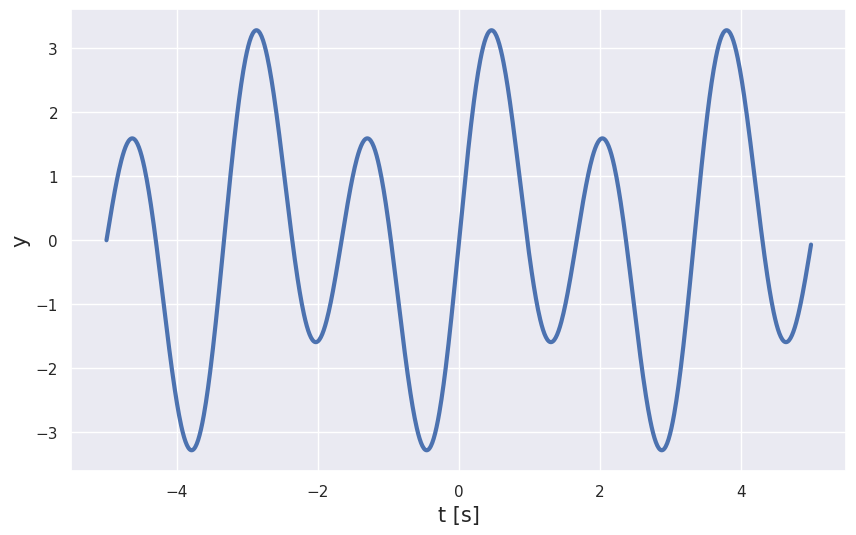

In [3]:
t_min, t_max = -5, 5
t_interval = 0.01
t = np.arange(t_min, t_max, t_interval)
y = analog_signal(t)

plt.figure(figsize=(10, 6))
plt.plot(t, y, linewidth=3)
plt.xlabel('t [s]' , fontsize=15)
plt.ylabel('y', fontsize=15);

## 信号の標本化（サンプリング）
先ほど作成した関数を**標本化**します。標本化はサンプリングとも言います。標本化はアナログデータを一定の時間間隔で区切り、その時間ごとの信号レベルを標本として抽出する処理となります。0.5秒おきに連続信号を読み取るとします。
以下のプログラムでは読み取る時間間隔をt_intervalに設定しています。

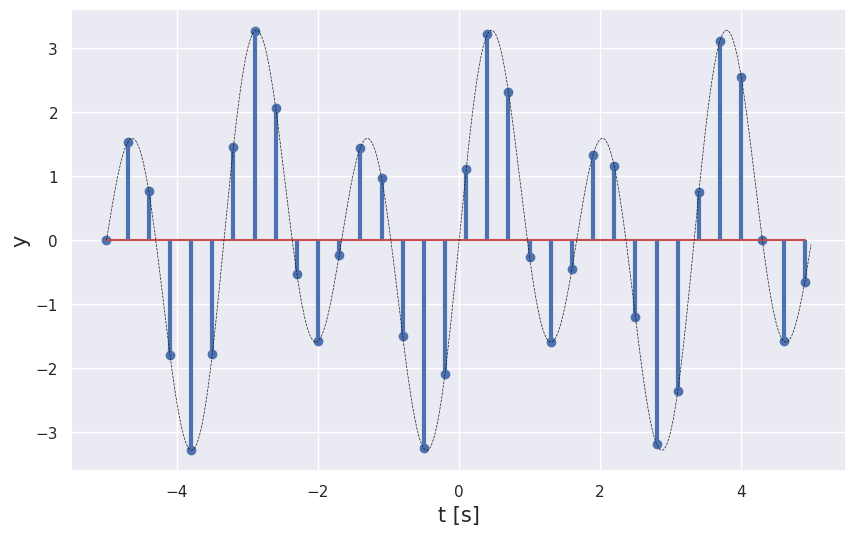

In [9]:
def plot_sampled_signal(t_interval=0.3):
  t_sampled= np.arange(t_min, t_max, t_interval) # t_interval 秒おきに取り出す
  y_sampled = analog_signal(t_sampled)

  plt.figure(figsize=(10, 6))
  markerline, stemlines, baseline = plt.stem(t_sampled, y_sampled)
  plt.setp(stemlines, 'linewidth', 3)
  plt.plot(t, y, 'k--', linewidth=0.5)

  plt.xlabel('t [s]' , fontsize = 15)
  plt.ylabel('y', fontsize = 15);

  return t_sampled, y_sampled


t_interval = 0.3
t_sampled, y_sampled = plot_sampled_signal(t_interval)

## 信号の量子化

サンプリングされた信号を**量子化**します。量子化は、信号の振幅を離散的な値に変換するプロセスです。ここでは、`n_bits`（ビット数）を指定することで、`2^n_bits`個の量子化レベルに信号を分割します。例えば、`n_bits=2`の場合、`2^2 = 4`つのレベルに信号が変換されます。

以下のコードでは、サンプリングされた信号 `y_sampled` の最小値と最大値に基づいて、均一な量子化レベルを設定し、各サンプリング点を対応する量子化レベルに丸めています。その後、元の連続信号とサンプリング点とともに、量子化された信号をプロットします。

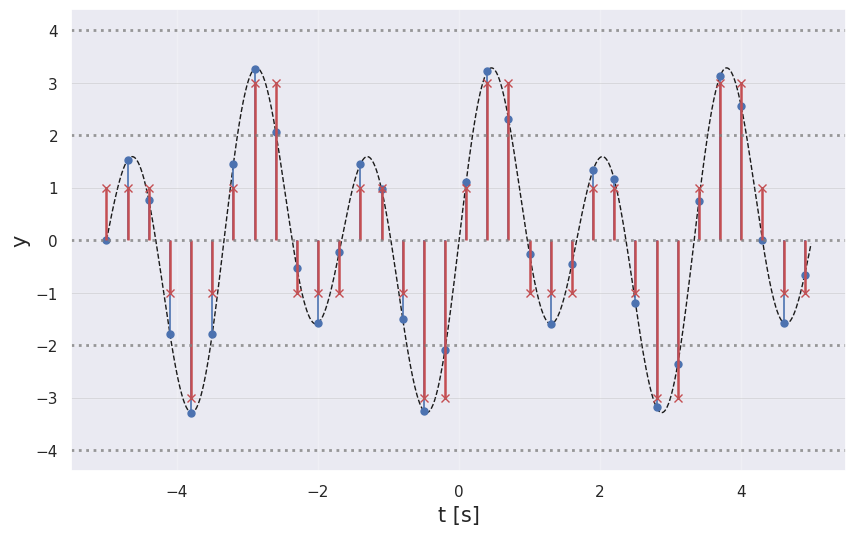

Quantizer settings (mid-rise):
  ymin=-4.0000, ymax=4.0000, Delta=2.0000, levels=4
First 10 samples:
  t=-5.00, y= 0.0000 -> k=2, yq= 1.0000
  t=-4.70, y= 1.5286 -> k=2, yq= 1.0000
  t=-4.40, y= 0.7634 -> k=2, yq= 1.0000
  t=-4.10, y=-1.7874 -> k=1, yq=-1.0000
  t=-3.80, y=-3.2821 -> k=0, yq=-3.0000
  t=-3.50, y=-1.7815 -> k=1, yq=-1.0000
  t=-3.20, y= 1.4546 -> k=2, yq= 1.0000
  t=-2.90, y= 3.2700 -> k=3, yq= 3.0000
  t=-2.60, y= 2.0622 -> k=3, yq= 3.0000
  t=-2.30, y=-0.5272 -> k=1, yq=-1.0000


In [11]:
n_bits = 2
L = 2**n_bits                               # 量子化レベル数（区間数）

# 量子化レンジ（授業では固定レンジにしてクリップも見せるのがおすすめ）
# ここでは連続信号のレンジを使う（サンプルのmin/maxにしない方が一貫性が出る）
# ymin = np.min(y)
# ymax = np.max(y)
ymin, ymax = -4.0, 4.0

# mid-rise のステップ幅（L個の区間に等分）
Delta = (ymax - ymin) / L

# 区間インデックス k = 0..L-1（境界で切って、区間に割り当て）
k = np.floor((y_sampled - ymin) / Delta).astype(int)
k = np.clip(k, 0, L-1)                      # レンジ外は飽和（クリップ）

# 出力は各区間の中心値（mid-rise）
y_quantized = ymin + (k + 0.5) * Delta

# 境界線（L+1本）と、中心値（L本）
boundaries = ymin + np.arange(L+1) * Delta
centers    = ymin + (np.arange(L) + 0.5) * Delta

# -----------------------------
# 4) プロット（整合する形）
# -----------------------------
plt.figure(figsize=(10, 6))

# 元の連続信号
plt.plot(t, y, 'k--', linewidth=1.0)

# サンプリング点（stem）
m1, s1, b1 = plt.stem(t_sampled, y_sampled, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.setp(s1, 'linewidth', 1.2)
plt.setp(m1, 'markersize', 5)

# 量子化後（stem）
m2, s2, b2 = plt.stem(t_sampled, y_quantized, linefmt='r-', markerfmt='rx', basefmt=' ')
plt.setp(s2, 'linewidth', 1.8)
plt.setp(m2, 'markersize', 6)

# 量子化境界線（点線）: boundaries
for yb in boundaries:
    plt.axhline(y=yb, color='gray', linestyle=':', linewidth=2.0, alpha=0.8)

# 量子化レベル中心（薄い実線）: centers（任意だが、図の整合が一目で分かる）
for yc in centers:
    plt.axhline(y=yc, color='gray', linestyle='-', linewidth=0.6, alpha=0.25)

# plt.title(f"Sampling & Quantization (mid-rise, n_bits={n_bits}, L={L})", fontsize=14)
plt.xlabel('t [s]' , fontsize = 15)
plt.ylabel('y', fontsize = 15);
plt.grid(True, alpha=0.25)
# plt.legend()
# plt.tight_layout()
plt.show()

# -----------------------------
# 5) 確認用の出力（任意）
# -----------------------------
print("Quantizer settings (mid-rise):")
print(f"  ymin={ymin:.4f}, ymax={ymax:.4f}, Delta={Delta:.4f}, levels={L}")
print("First 10 samples:")
for i in range(min(10, len(y_sampled))):
    print(f"  t={t_sampled[i]: .2f}, y={y_sampled[i]: .4f} -> k={k[i]}, yq={y_quantized[i]: .4f}")

In [14]:
import matplotlib.pyplot as plt

def plot_quantized_square_wave(t, y, t_sampled, y_sampled, y_quantized, boundaries, centers):
    """
    連続アナログ信号が標本化・量子化によって矩形波に変換される様子をプロットします。

    Args:
        t (np.ndarray): 連続信号の時間軸データ。
        y (np.ndarray): 連続信号の振幅データ。
        t_sampled (np.ndarray): 標本化された信号の時間軸データ。
        y_sampled (np.ndarray): 標本化された信号の振幅データ。
        y_quantized (np.ndarray): 量子化された信号の振幅データ。
        boundaries (np.ndarray): 量子化の境界値。
        centers (np.ndarray): 量子化レベルの中心値。
    """
    plt.figure(figsize=(12, 7))

    # 元の連続信号をプロット
    plt.plot(t, y, 'k--', linewidth=1.0, label='Original Analog Signal')

    # 標本化された点をプロット
    plt.plot(t_sampled, y_sampled, 'bo', markersize=6, label='Sampled Points')

    # 量子化された信号をステップ状にプロット（矩形波表現）
    plt.step(t_sampled, y_quantized, 'r-', linewidth=2.5, where='post', label='Quantized (Square Wave)')

    # 量子化の境界線をプロット
    for yb in boundaries:
        plt.axhline(y=yb, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

    # 量子化レベルの中心値をプロット
    for yc in centers:
        plt.axhline(y=yc, color='gray', linestyle='-', linewidth=0.5, alpha=0.2)

    # plt.title('Conversion of Analog Signal to Quantized (Square Wave) Signal', fontsize=16)
    plt.xlabel('t [s]', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.grid(True, alpha=0.3)
    # plt.legend(fontsize=12)
    # plt.tight_layout()
    plt.show()

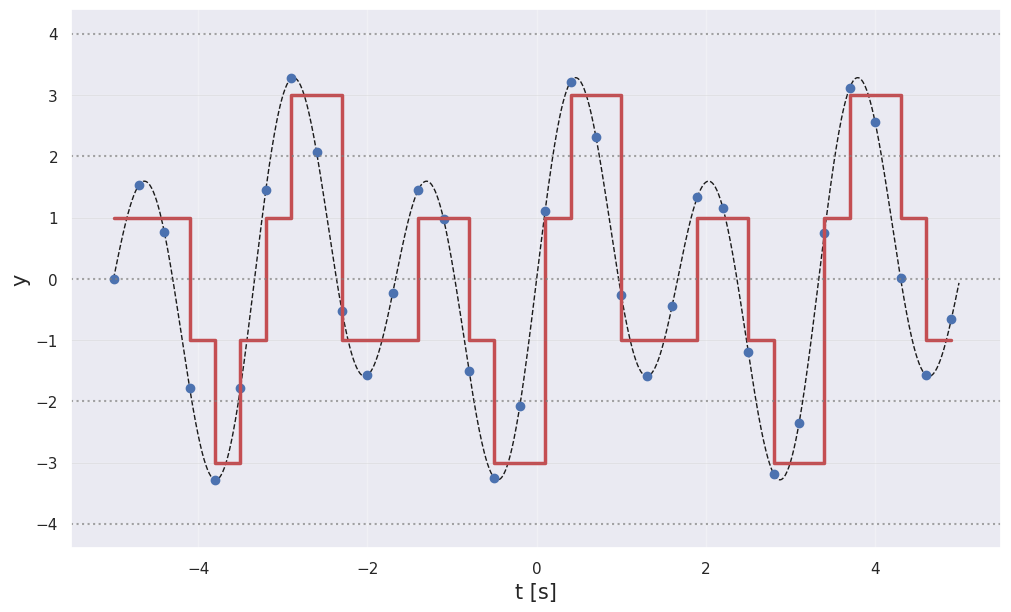

In [15]:
# 上で定義した関数を使って、標本化・量子化による矩形波への変換図をプロットします。
# 必要な変数は、以前のセルで計算され、カーネルの状態に存在します。
plot_quantized_square_wave(t, y, t_sampled, y_sampled, y_quantized, boundaries, centers)